In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yaml
import os
from collections import Counter

In [ ]:
os.chdir(
    ".."
)  # Change working directory to root of repository for paths to be consistent

In [8]:
with open("config/params.yaml") as f:
    params = yaml.safe_load(f)

# Load the data files
train_file = params["files"]["train"]
test_file = params["files"]["test"]
output_file = params["files"]["output"]

train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# Check the data
print(train_data.head())

  Sequence  Active
0     DKWL       0
1     FCHN       0
2     KDQP       0
3     FNWI       0
4     NKRM       0


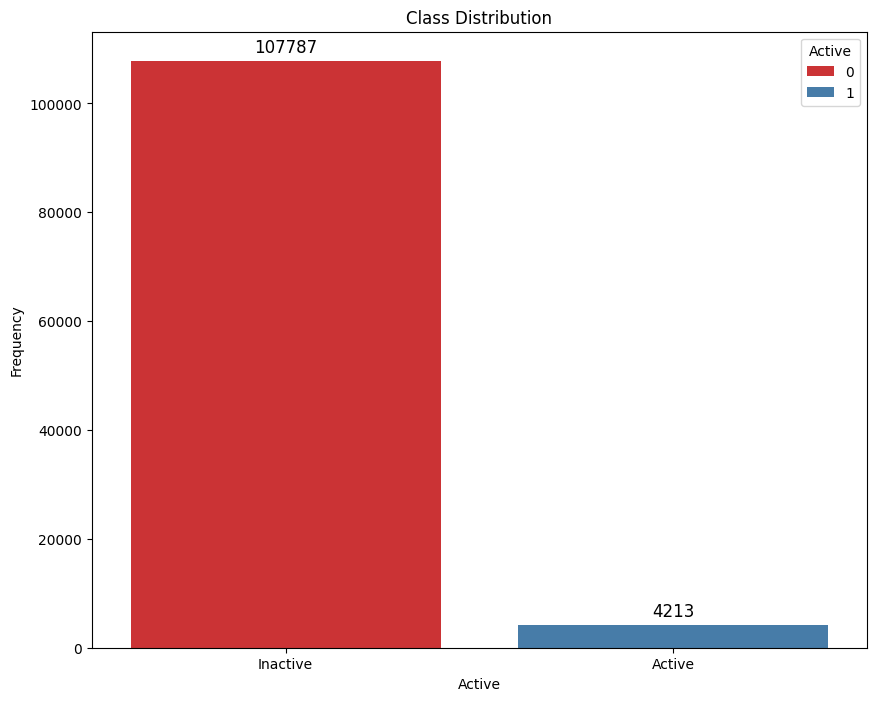

In [27]:
labels = train_data["Active"]

class_counts = labels.value_counts()

# Plot the class distribution
plt.figure(figsize=(10, 8))
ax = sns.countplot(x=labels, palette="Set1", hue=labels)
plt.title("Class Distribution")
plt.xlabel("Active")
plt.ylabel("Frequency")
plt.xticks(ticks=[0, 1], labels=["Inactive", "Active"])

# Add the count labels on top of the bars
for p in ax.patches:
    count = int(p.get_height())  # Get the count of the bar
    if p.get_width() > 0:
        ax.annotate(
            f"{count}",  # Display the count
            (p.get_x() + p.get_width() / 2.0, p.get_height()),  # Position of the label
            ha="center",
            va="center",  # Horizontal and vertical alignment
            fontsize=12,
            color="black",  # Font size and color
            xytext=(0, 10),  # Offset the label slightly above the bar
            textcoords="offset points",
        )

plt.show()

In [48]:
# Constants
AMINOACIDS = [
    "A",
    "C",
    "D",
    "E",
    "F",
    "G",
    "H",
    "I",
    "K",
    "L",
    "M",
    "N",
    "P",
    "Q",
    "R",
    "S",
    "T",
    "V",
    "W",
    "Y",
    ]
CHARGED_AA = ["R", "H", "K", "D", "E"]

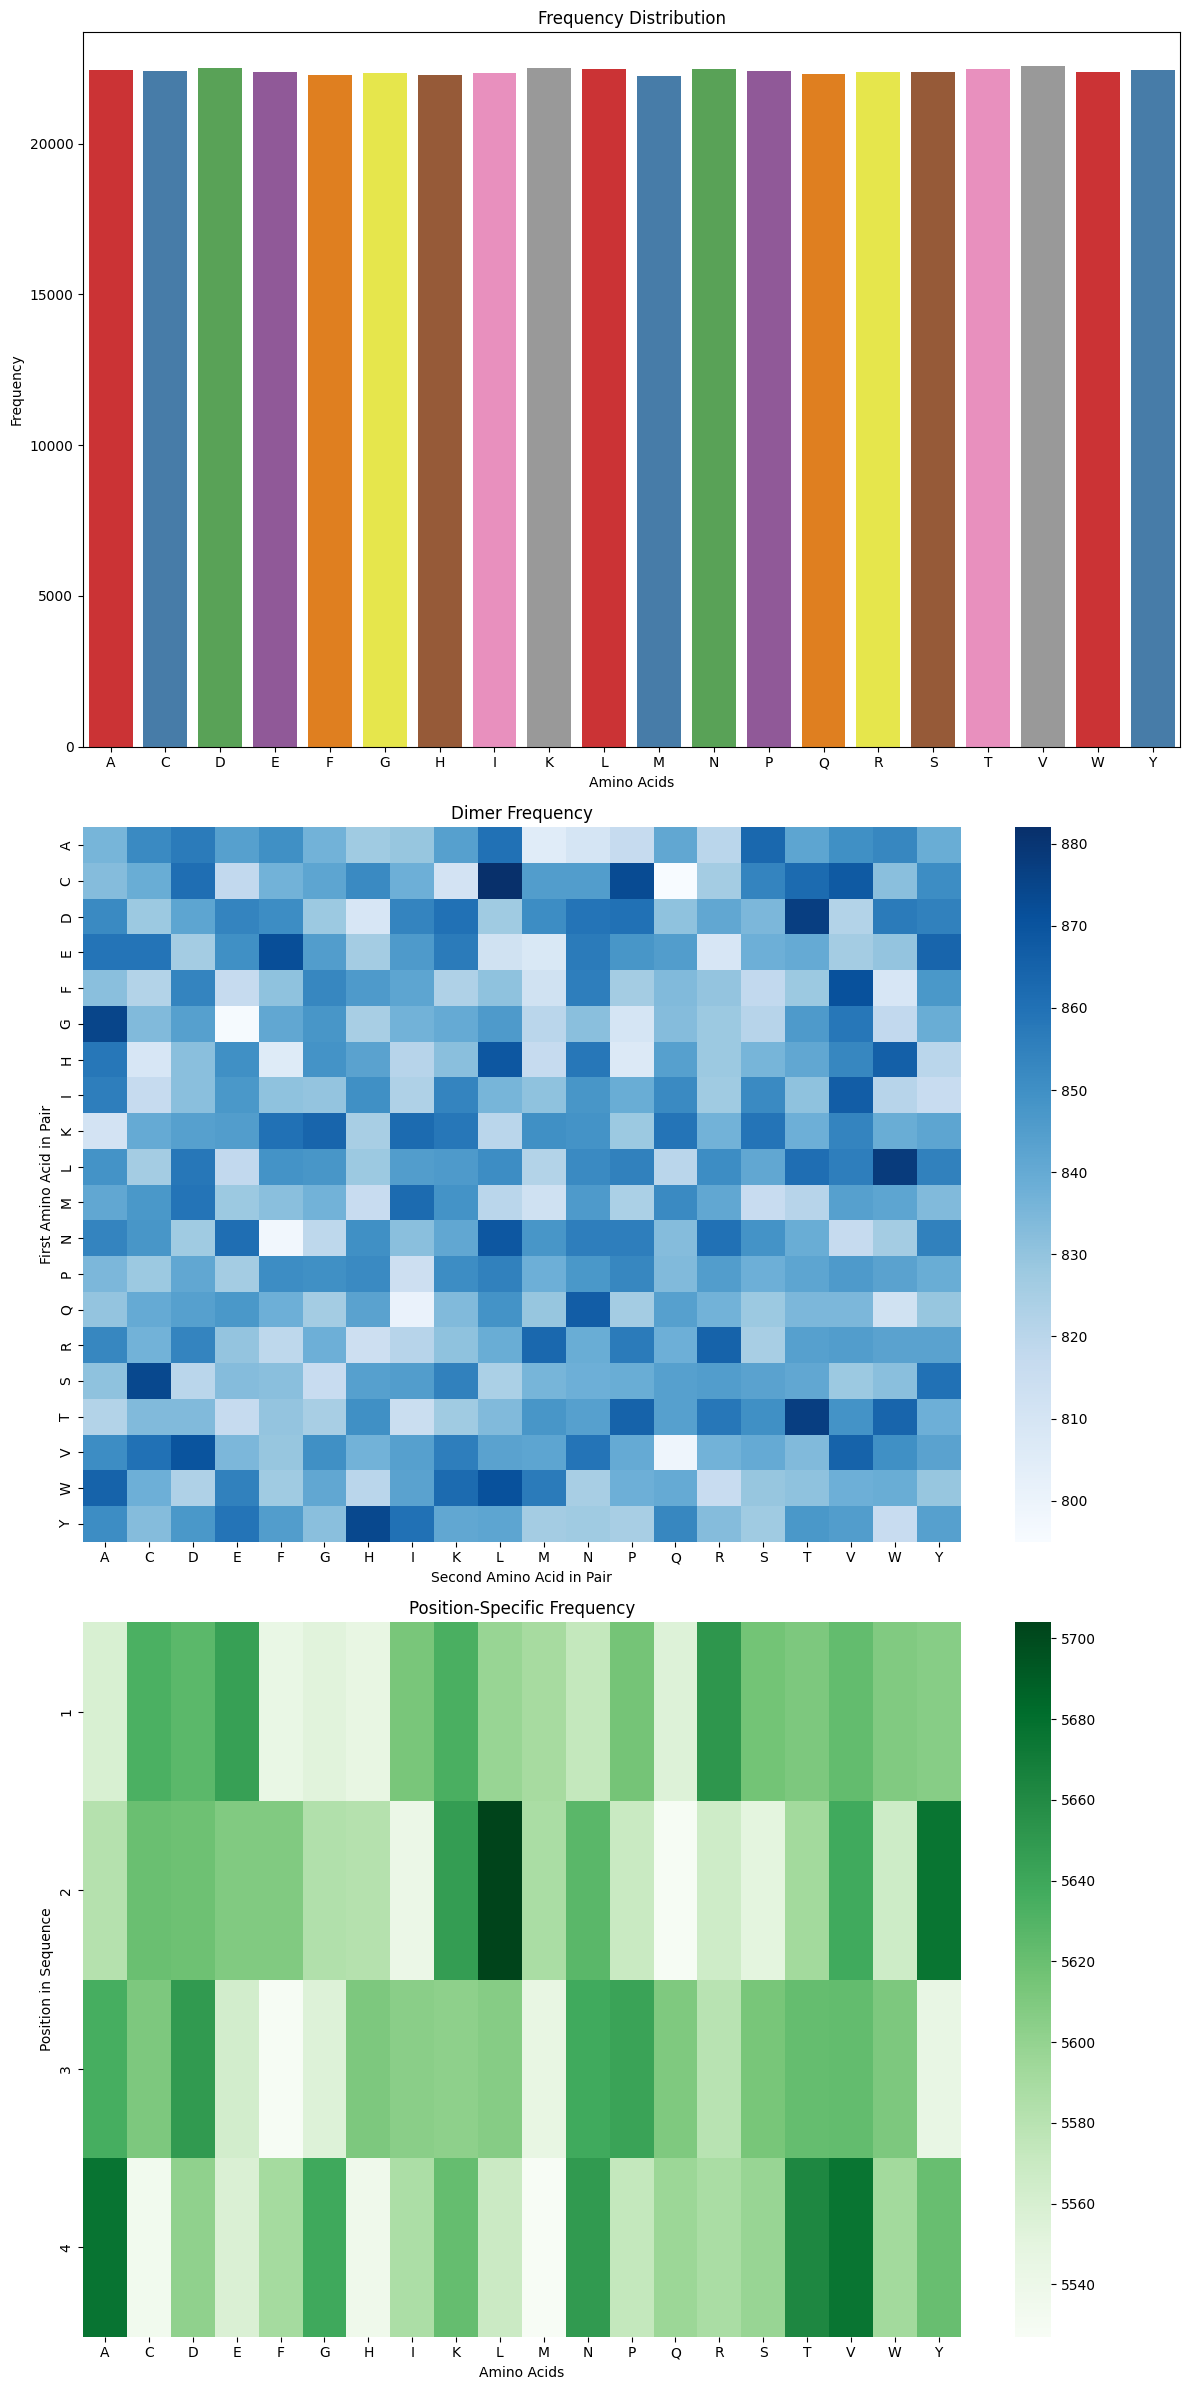

In [50]:
features = train_data["Sequence"]

# 1. Frequency Distribution
# Flatten the list of sequences to a single list of amino acids
all_aa = "".join(features.values)
aa_counts = Counter(all_aa)
aa_counts = dict(sorted(aa_counts.items()))

# 2. Dimer Frequency
# Generate all adjacent pairs (dimers)
pairs = [seq[i : i + 2] for seq in features for i in range(len(seq) - 1)]
pair_counts = Counter(pairs)

# Create a 2D matrix for the dimer heatmap
pair_matrix = np.zeros((len(AMINOACIDS), len(AMINOACIDS)))

for pair, count in pair_counts.items():
    i, j = AMINOACIDS.index(pair[0]), AMINOACIDS.index(pair[1])
    pair_matrix[i, j] = count

# 3. Position-Specific Frequency
# Transpose the sequences so each row is a position and each column is an amino acid
sequences_transposed = list(zip(*features))
positions = len(sequences_transposed)

# Count the occurrence of each amino acid at each position
aa_positions = []
for i in range(positions):
    aa_count = Counter(sequences_transposed[i])
    aa_positions.append(aa_count)

# Convert position-specific counts to a matrix
position_matrix = np.zeros((positions, len(AMINOACIDS)))

for i, count in enumerate(aa_positions):
    for aa, c in count.items():
        position_matrix[i, AMINOACIDS.index(aa)] = c

# Plot all subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 24))

# Frequency Distribution Plot
sns.barplot(
    x=list(aa_counts.keys()),
    y=list(aa_counts.values()),
    ax=axes[0],
    palette="Set1",
    hue=list(aa_counts.keys()),
)
axes[0].set_title("Frequency Distribution")
axes[0].set_xlabel("Amino Acids")
axes[0].set_ylabel("Frequency")

# Dimer Frequency Heatmap
sns.heatmap(
    pair_matrix,
    xticklabels=AMINOACIDS,
    yticklabels=AMINOACIDS,
    cmap="Blues",
    # annot=True,
    ax=axes[1],
)
axes[1].set_title("Dimer Frequency")
axes[1].set_xlabel("Second Amino Acid in Pair")
axes[1].set_ylabel("First Amino Acid in Pair")

# Position-Specific Frequency Heatmap
sns.heatmap(
    position_matrix,
    xticklabels=AMINOACIDS,
    yticklabels=range(1, positions + 1),
    cmap="Greens",
    # annot=True,
    ax=axes[2],
)
axes[2].set_title("Position-Specific Frequency")
axes[2].set_xlabel("Amino Acids")
axes[2].set_ylabel("Position in Sequence")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

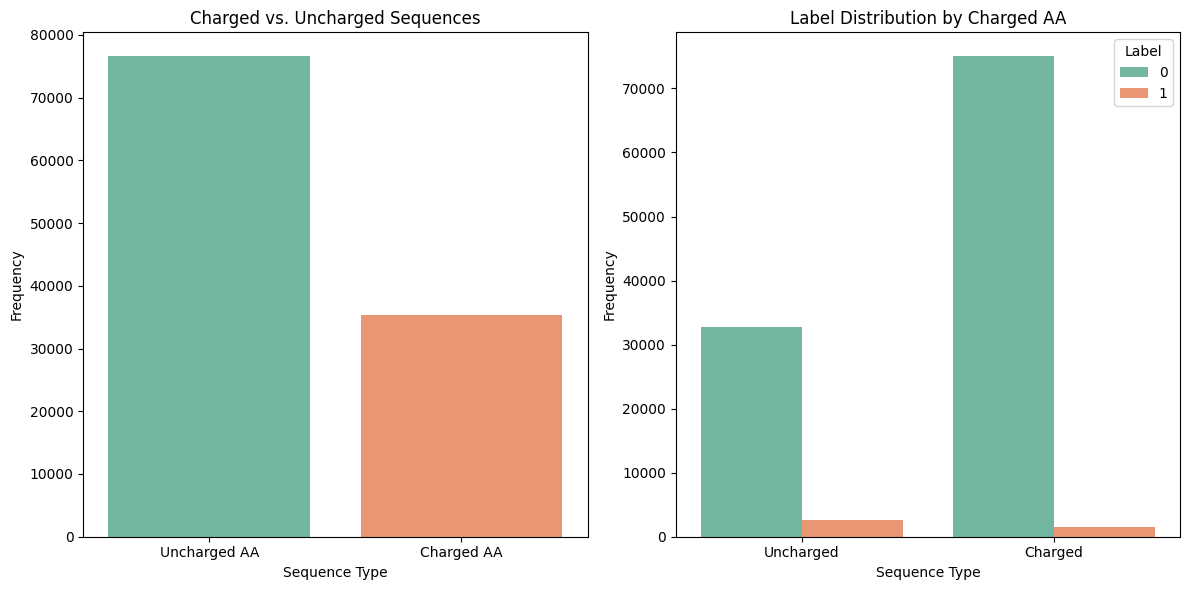

In [69]:
charged_seq = features.apply(lambda seq: any(aa in seq for aa in CHARGED_AA))
charged_counts = charged_seq.value_counts()
charged_counts.index = ["Uncharged AA", "Charged AA"]

# Plot proportion of charged vs. uncharged sequences
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=charged_counts.index, y=charged_counts.values, palette="Set2", hue=charged_counts.index)
plt.title("Charged vs. Uncharged Sequences")
plt.ylabel("Frequency")
plt.xlabel("Sequence Type")

# Label distribution for charged and uncharged sequences
charged_activity = pd.DataFrame({"Charged Sequences": charged_seq, "Active": labels})
grouped_counts = charged_activity.groupby(["Charged Sequences", "Active"]).size().reset_index(name="Frequency")

# Plot stacked bar chart for label distribution
plt.subplot(1, 2, 2)
sns.barplot(
    data=grouped_counts,
    x="Charged Sequences",
    y="Frequency",
    hue="Active",
    palette="Set2",
)
plt.title("Label Distribution by Charged AA")
plt.xlabel("Sequence Type")
plt.ylabel("Frequency")
plt.xticks(ticks=[0, 1], labels=["Uncharged", "Charged"])
plt.legend(title="Label")

plt.tight_layout()
plt.show()